## Importing the input vectors

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from functools import partial
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Run the data preparation notebook
testdf = np.load("npy_files/X_analog_feb_july.npy", allow_pickle=True)

X_analog = testdf[:,:-2].astype(np.float32)
anomaly_list = testdf[:,-1] #0 for normal. 1 for anomaly
timestamps = testdf[:,-2]
timestamps = pd.to_datetime(timestamps)


In [2]:
X_analog.shape

(9665, 16)

In [3]:
pd.DataFrame(X_analog[0,:]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,8.642,9.736,9.728,9.32,8.926,8.558,8.228,6.05,6.15,3.855,0.04,0.04,0.04,0.0375,109.0,1942.0


#### Deciding the different sets' sizes and positions

#### Defining Autoencoder, loss and prediction functions

In [7]:
# Define input dimension
input_dim = X_analog.shape[1]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(128, activation='sigmoid', name='encoder_layer1')(input_layer)
encoded = Dense(64, activation='sigmoid', name='encoder_layer2')(encoded)
encoded = Dense(32, activation='sigmoid', name='encoder_layer3')(encoded)
bottleneck = Dense(12, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(32, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoded = Dense(64, activation='sigmoid', name='decoder_layer2')(decoded)
decoded = Dense(128, activation='sigmoid', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss
    

# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label=0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label=0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label=0)))

#### Operator to tell the first cycle of a given month

In [8]:
np.where(timestamps.month == 4)[0][0]

np.int64(2954)

#### Boundary condition: the primordial run

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 61.7644
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.0226
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11.2307
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5619
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7720
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4590
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4694
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7072
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1015
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6173
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2233
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8976
Epoch 13/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6281
Epoch 14/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4030
Epoch 15/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2159
E

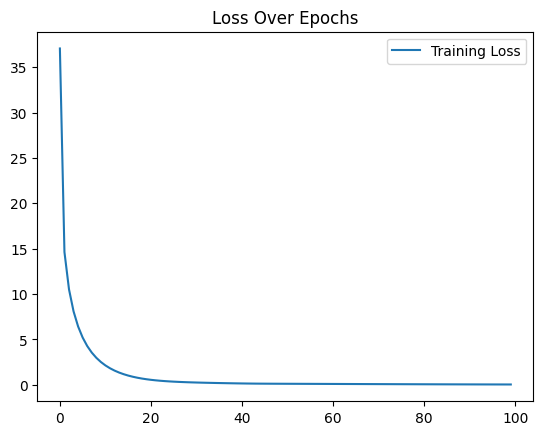

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold:  0.1630123
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [9]:
#Boundary condition: primordial run

# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_analog

#new variables for the moving window problem
test_loss = []
preds_list = []
threshold_list = []

normal_train_data = np.empty((0, 16), dtype=np.float32)  # Empty array with correct shape
anomalous_train_data = np.empty((0, 16), dtype=np.float32)


test_cycle_normalized = np.empty((1, 16), dtype=np.float32)
test_cycle = np.empty((1, 16), dtype=np.float32)
good_cycles = np.empty((1,16), dtype=np.float32)


# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
index_mar = 1180+1 #March 1st index (+1 bc 1st cycle is problematic)
index_apr = 2954
index_mai = 4193 
index_jun = 5815
index_jul = 7611
time_delta = 7 # how many days at a time you want to test
last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=time_delta)) #Determine the last index of the test set

# Split the data and labels
train_data = data[index_mar:index_apr].astype(np.float32)
#val_data = data[split_index:split_index2]
test_data = data[index_apr:last_test_index].astype(np.float32) # Assuring we only test 1 week at a time

train_labels = labels[index_mar:index_apr]
#val_labels = labels[split_index:split_index2]
test_labels = labels[index_apr:last_test_index]# Assuring we only test 1 week at a time

#Pass to boolean
train_labels = train_labels.astype(bool)
#val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Separate into normal and anomalous data
for i in range(len(train_labels)):
    if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :]), axis=0)
    else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :]), axis=0)

normal_train_data_normalized = np.zeros_like(normal_train_data)
test_data_normalized = np.zeros_like(test_data)




scaler = MinMaxScaler()
normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)

# Fit and transform sensor 2 (columns 7-13)
normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)

# Fit and transform Trun (column 14)
normal_train_data_normalized[:, 14] = scaler.fit_transform(normal_train_data[:, 14].reshape(-1, 1)).flatten()
test_data_normalized[:, 14] = scaler.transform(test_data[:, 14].reshape(-1, 1)).flatten()

# Fit and transform Tidle (column 15)
normal_train_data_normalized[:, 15] = scaler.fit_transform(normal_train_data[:, 15].reshape(-1, 1)).flatten()
test_data_normalized[:, 15] = scaler.transform(test_data[:, 15].reshape(-1, 1)).flatten()



# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_normalized,  # Input and target are the same for autoencoders
    y=normal_train_data_normalized,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_train = autoencoder.predict(normal_train_data_normalized)
val_loss = tf.keras.losses.mae(reconstructions_train, normal_train_data_normalized)

# Compute the first quartile (Q1) and third quartile (Q3)
Q1 = np.percentile(val_loss, 25)
Q3 = np.percentile(val_loss, 75)
IQR = Q3 - Q1
# Define the threshold using Tukey's fence - 1.5 for outliers. 3 for far-out results
k = 3
threshold = Q3 + k * IQR
threshold_list.append(threshold)
print("Threshold: ", threshold)

# Calculate the reconstruction loss for the anomalous test data
reconstructions_test = autoencoder.predict(test_data_normalized)
pred_aux = predict(autoencoder, test_data_normalized, threshold)
preds_list = np.concatenate((preds_list, pred_aux), axis=0)

test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())


#### Moving window

In [10]:
n = 1
break_flag = False

#Computing number of cycles
for j in range(len(pred_aux)):
    try:
        next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=j*time_delta))
        num_cycles = j
    except:
        break


while True:
    try:
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=n*time_delta))
        last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=(n+1)*time_delta))
        print(f"Cycle: {n+1}/{num_cycles+1}")
        for j in range(len(pred_aux)):
            if pred_aux[j] == True:
                np.delete(normal_train_data, np.s_[:1], axis=0)
                normal_train_data = np.append(normal_train_data, [test_data[j,:]], axis=0)
        test_data = data[last_test_index:last_test_index_2]

    except:
        last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[2954]+pd.Timedelta(days=n*time_delta))
        print(f"Cycle: {n+1}/{num_cycles+1}")
        for j in range(len(pred_aux)):
            if pred_aux[j] == True:
                np.delete(normal_train_data, np.s_[:1], axis=0)
                normal_train_data = np.append(normal_train_data, [test_data[j,:]], axis=0)
        test_data = data[last_test_index:]

        break_flag = True


    normal_train_data_normalized = np.zeros_like(normal_train_data)
    test_data_normalized = np.zeros_like(test_data)


    scaler = MinMaxScaler()
    normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)

    # Fit and transform sensor 2 (columns 7-13)
    normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
    test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)

    # Fit and transform Trun (column 14)
    normal_train_data_normalized[:, 14] = scaler.fit_transform(normal_train_data[:, 14].reshape(-1, 1)).flatten()
    test_data_normalized[:, 14] = scaler.transform(test_data[:, 14].reshape(-1, 1)).flatten()

    # Fit and transform Tidle (column 15)
    normal_train_data_normalized[:, 15] = scaler.fit_transform(normal_train_data[:, 15].reshape(-1, 1)).flatten()
    test_data_normalized[:, 15] = scaler.transform(test_data[:, 15].reshape(-1, 1)).flatten()




    # Compile the model with the custom loss
    autoencoder.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
    )

    # Train the model
    history = autoencoder.fit(
        x=normal_train_data_normalized,  # Input and target are the same for autoencoders
        y=normal_train_data_normalized,  # Input and target are the same for autoencoders
        epochs=100, 
        batch_size=30
    )





    # Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
    reconstructions_train = autoencoder.predict(normal_train_data_normalized)
    val_loss = tf.keras.losses.mae(reconstructions_train, normal_train_data_normalized)

    # Compute the first quartile (Q1) and third quartile (Q3)
    Q1 = np.percentile(val_loss, 25)
    Q3 = np.percentile(val_loss, 75)
    IQR = Q3 - Q1
    # Define the threshold using Tukey's fence - 1.5 for outliers. 3 for far-out results
    k = 3
    threshold = Q3 + k * IQR
    threshold_list.append(threshold)
    print("Threshold: ", threshold)

    # Calculate the reconstruction loss for the anomalous test data
    reconstructions_test = autoencoder.predict(test_data_normalized)
    pred_aux = []
    pred_aux = predict(autoencoder, test_data_normalized, threshold)
    preds_list = np.concatenate((preds_list, pred_aux), axis=0)

    test_loss.extend(tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy())
    if break_flag==True:
        break

    n += 1

Cycle: 2/18
Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0348
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0326
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0314
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0313
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0291
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0305
Epoch 13/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0286
Epoch 14/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0307
Epoch 15/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

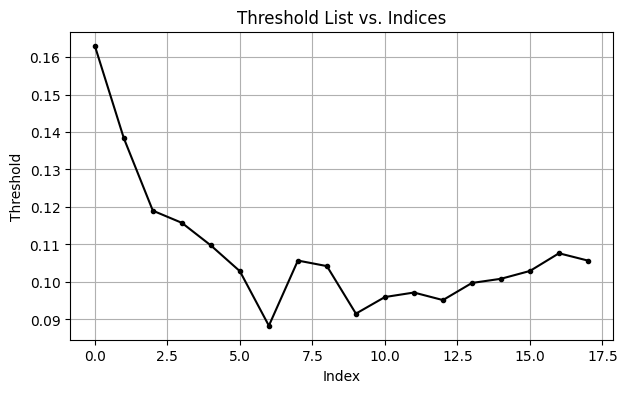

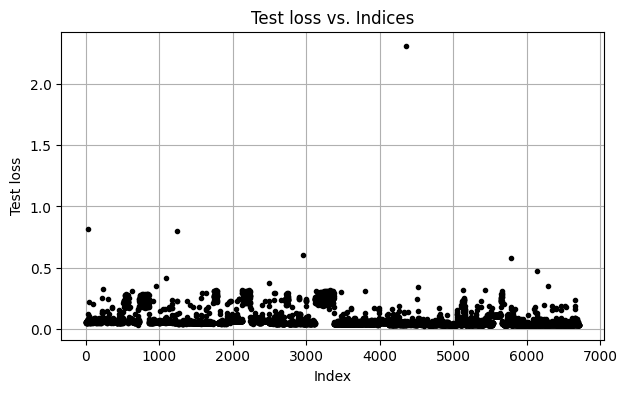

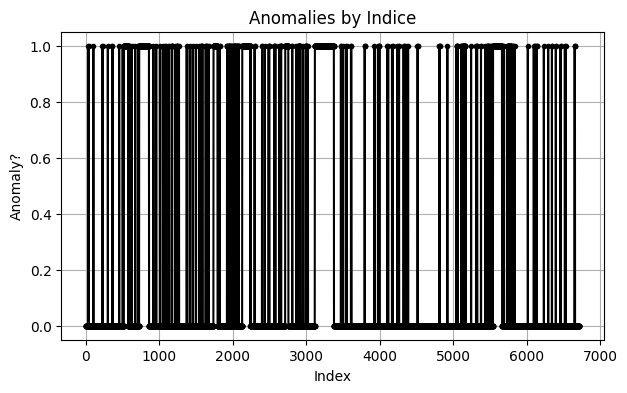

In [11]:
# Plot threshold_list against the respective indices
plt.figure(figsize=(7, 4))
plt.plot(threshold_list, marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Threshold')
plt.title('Threshold List vs. Indices')
plt.grid(True)
#plt.ylim(0,0.0075)
plt.show()


# Plot test_loss against the respective indices
plt.figure(figsize=(7, 4))
plt.plot(test_loss, marker='.', linestyle=' ', color='black')
plt.xlabel('Index')
plt.ylabel('Test loss')
plt.title('Test loss vs. Indices')
plt.grid(True)
#plt.ylim(0,0.0075)
plt.show()



# Convert boolean values: True -> 0, False -> 1
plot_preds_list = [0 if pred else 1 for pred in preds_list]

# Plot the converted preds_list
plt.figure(figsize=(7, 4))
plt.plot(plot_preds_list, marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Anomalies by Indice')
plt.grid(True)
plt.show()

#### Low pass filter

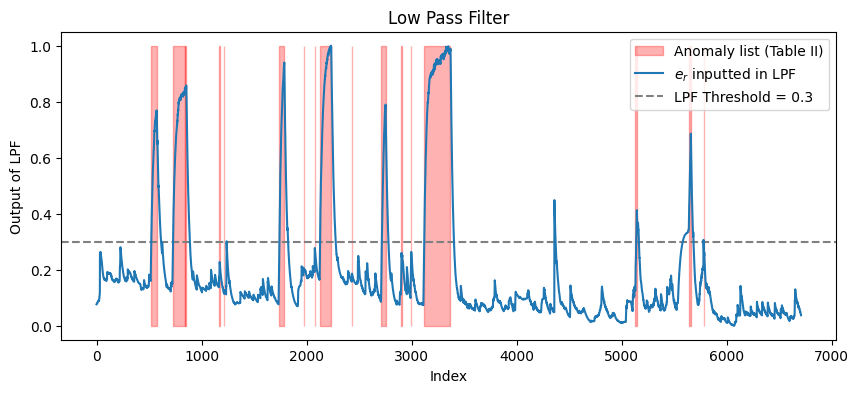

In [44]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Reshape test_loss to a 2D array and fit and transform it
test_loss_normalized = scaler.fit_transform(np.array(test_loss).reshape(-1, 1)).flatten()

def low_pass_filter(data, alpha):
    y = np.zeros_like(data)
    y[0] = data[0]
    for i in range(1, len(data)):
        y[i] = y[i-1] + alpha * (data[i] - y[i-1])
    return y

# Example usage
alpha = 0.04  # You can adjust this hyperparameter
lpf_output = low_pass_filter(test_loss_normalized, alpha)
lpf_output_normalized = scaler.fit_transform(np.array(lpf_output).reshape(-1, 1)).flatten()
lpf_threshold = 0.3

# Plot the original and filtered data
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(anomaly_list[index_apr:])), 0, 1, where=np.array(anomaly_list[index_apr:]) == 1, color='red', alpha=0.3, label='Anomaly list (Table II)')
plt.axhline(y=lpf_threshold, color='gray', linestyle='--')
plt.plot(lpf_output_normalized, label="$e_r$ inputted in LPF", linestyle='-')
custom_legend = [Line2D([0], [0], color='gray', linestyle='--', label=f"LPF Threshold = {lpf_threshold}")]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, loc='upper right')
plt.title('Low Pass Filter')
#plt.ylim(0,0.11)
plt.xlabel('Index')
plt.ylabel('Output of LPF')
plt.show()

#### Metrics and Confusion Matrix

In [ ]:
final_preds = []
for i in lpf_output_normalized:
    if i >= lpf_threshold:
        final_preds.append(1)
    else:
        final_preds.append(0)
        
# Ensure both lists are binary and have the same data type
anomaly_list_binary = np.array(anomaly_list[index_apr:], dtype=int)

# Generate the confusion matrix
cm = confusion_matrix(anomaly_list_binary, final_preds)

print("Confusion Matrix:")
print(f"{cm}\n")

print("Accuracy = {}%".format(100*accuracy_score(anomaly_list_binary, final_preds)))
print("Precision = {}%".format(100*precision_score(anomaly_list_binary, final_preds, pos_label=1)))
print("Recall = {}%".format(100*recall_score(anomaly_list_binary, final_preds, pos_label=1)))
print("F1 Score = {}%".format(100*f1_score(anomaly_list_binary, final_preds, pos_label=1)))

Confusion Matrix:
[[5679  338]
 [  55  639]]

Accuracy = 94.14394278050962%
Precision = 65.4042988741044%
Recall = 92.0749279538905%
F1 Score = 76.48114901256733%
